# Complete Readmission Prediction Pipeline

This notebook combines all processes from Part 2:
1. Data generation
2. Data preprocessing (missing values, feature engineering, encoding)
3. Model training and evaluation
4. Model saving for deployment

Author: Peter Kamau Mwaura

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("READMISSION PREDICTION PIPELINE")
print("="*60)

READMISSION PREDICTION PIPELINE


In [2]:
# Create directories
data_dir = Path('data')
src_dir = Path('src')
data_dir.mkdir(exist_ok=True)
src_dir.mkdir(exist_ok=True)

## Step 1: Data Generation

In [3]:
print("\n" + "="*60)
print("STEP 1: DATA GENERATION")
print("="*60)

# Set random seed for reproducibility
np.random.seed(42)

# Number of patient records to generate
n_samples = 1000

print(f"Generating {n_samples} synthetic patient records...")

# Generate patient demographics
age = np.random.randint(18, 96, size=n_samples)
gender = np.random.choice(['Male', 'Female', 'Other'], size=n_samples, p=[0.48, 0.50, 0.02])

# Generate admission type
admission_type = np.random.choice(['Emergency', 'Elective', 'Urgent'], 
                                  size=n_samples, p=[0.50, 0.25, 0.25])

# Generate length of stay (skewed distribution - most patients stay shorter)
length_of_stay = np.random.exponential(scale=5, size=n_samples)
length_of_stay = np.clip(np.round(length_of_stay).astype(int), 1, 30)

# Generate lab procedures (correlated with length of stay and age)
num_lab_procedures = np.random.poisson(lam=20, size=n_samples)
num_lab_procedures = np.clip(num_lab_procedures + (length_of_stay // 3), 0, 100)

# Generate medications (correlated with age and length of stay)
num_medications = np.random.poisson(lam=8, size=n_samples)
num_medications = np.clip(num_medications + (age // 15) + (length_of_stay // 5), 1, 40)

# Generate diagnosis codes (common medical conditions)
diagnosis_codes = ['I10', 'E11', 'J44', 'F32', 'M79', 'N18', 'K21', 'I50']
diagnosis_code = np.random.choice(diagnosis_codes, size=n_samples, 
                                  p=[0.25, 0.20, 0.15, 0.10, 0.08, 0.08, 0.07, 0.07])

# Generate target variable (readmitted) with correlations
readmission_prob = np.zeros(n_samples)

for i in range(n_samples):
    prob = 0.2  # Base readmission probability
    
    # Age factor
    if age[i] > 65:
        prob += 0.15
    elif age[i] > 50:
        prob += 0.08
    
    # Length of stay factor
    if length_of_stay[i] > 14:
        prob += 0.20
    elif length_of_stay[i] > 7:
        prob += 0.10
    
    # Diagnosis code factor
    high_risk_diagnoses = ['I10', 'E11', 'J44', 'N18']
    if diagnosis_code[i] in high_risk_diagnoses:
        prob += 0.15
    
    # Medication count factor
    if num_medications[i] > 15:
        prob += 0.10
    
    # Admission type factor
    if admission_type[i] == 'Emergency':
        prob += 0.05
    
    readmission_prob[i] = min(prob, 0.85)  # Cap at 85%

# Generate binary readmission outcome based on probabilities
readmitted = np.random.binomial(1, readmission_prob, size=n_samples)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'gender': gender,
    'admission_type': admission_type,
    'length_of_stay': length_of_stay,
    'num_lab_procedures': num_lab_procedures,
    'num_medications': num_medications,
    'diagnosis_code': diagnosis_code,
    'readmitted': readmitted
})

# Save to CSV
output_path = data_dir / 'synthetic_patient_data.csv'
df.to_csv(output_path, index=False)

print(f"✓ Dataset generated successfully!")
print(f"✓ Saved to: {output_path}")
print(f"  - Total records: {len(df)}")
print(f"  - Readmission rate: {df['readmitted'].mean():.2%}")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())


STEP 1: DATA GENERATION
Generating 1000 synthetic patient records...
✓ Dataset generated successfully!
✓ Saved to: data\synthetic_patient_data.csv
  - Total records: 1000
  - Readmission rate: 40.90%

First 5 rows:
   age  gender admission_type  length_of_stay  num_lab_procedures  \
0   69    Male       Elective               2                  15   
1   32  Female      Emergency               4                  22   
2   89  Female      Emergency               8                  27   
3   78    Male      Emergency               1                  27   
4   38    Male      Emergency               8                  17   

   num_medications diagnosis_code  readmitted  
0               11            N18           1  
1               12            M79           0  
2               18            I10           1  
3               15            E11           0  
4                9            F32           0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 

## Step 2: Data Preprocessing

In [4]:
print("\n" + "="*60)
print("STEP 2: DATA PREPROCESSING")
print("="*60)

# Introduce random missing values to simulate real-world data
np.random.seed(42)

# Introduce 5% missing values in numerical columns
numerical_cols = ['age', 'length_of_stay', 'num_lab_procedures', 'num_medications']
for col in numerical_cols:
    missing_indices = np.random.choice(df.index, size=int(len(df) * 0.05), replace=False)
    df.loc[missing_indices, col] = np.nan

# Introduce 3% missing values in categorical columns
categorical_cols = ['gender', 'admission_type', 'diagnosis_code']
for col in categorical_cols:
    missing_indices = np.random.choice(df.index, size=int(len(df) * 0.03), replace=False)
    df.loc[missing_indices, col] = np.nan

print("Missing values introduced for simulation.")

# Impute numerical columns with mean
for col in numerical_cols:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)
    print(f"Imputed {col} with mean: {mean_value:.2f}")

# Impute categorical columns with mode
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
    print(f"Imputed {col} with mode: {mode_value}")

print("✓ Missing values handled!")


STEP 2: DATA PREPROCESSING
Missing values introduced for simulation.
Imputed age with mean: 55.57
Imputed length_of_stay with mean: 5.16
Imputed num_lab_procedures with mean: 21.11
Imputed num_medications with mean: 12.01
Imputed gender with mode: Female
Imputed admission_type with mode: Emergency
Imputed diagnosis_code with mode: I10
✓ Missing values handled!


✓ Comorbidity score feature created!


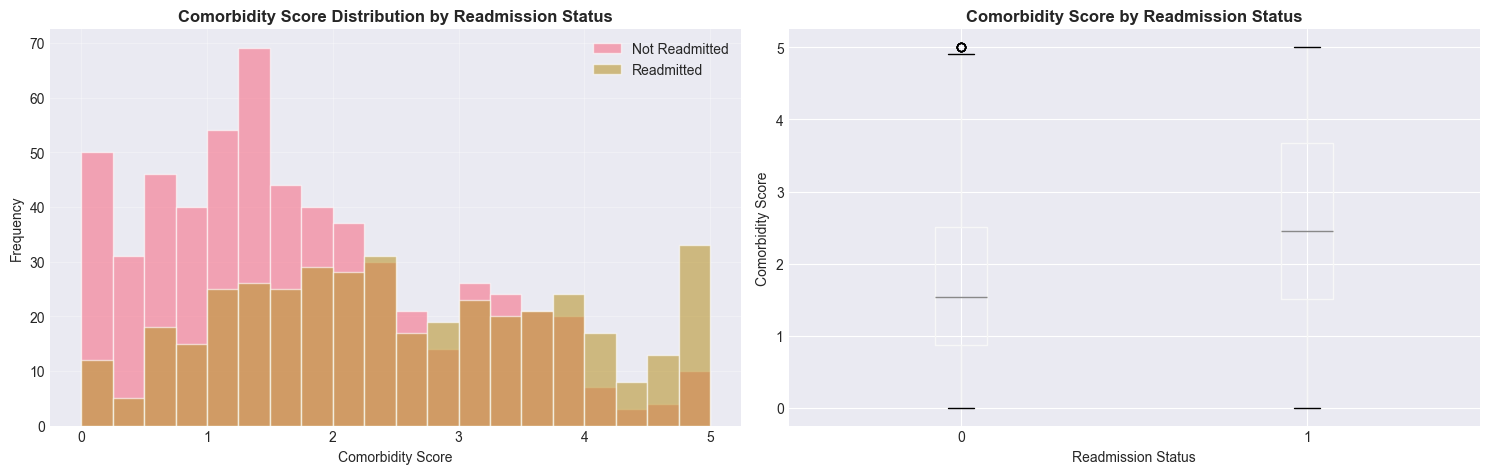

In [5]:
# Feature engineering: comorbidity score
np.random.seed(42)
comorbidity_scores = []

for idx, row in df.iterrows():
    score = 0
    
    # Age factor (older patients have higher scores)
    if row['age'] > 75:
        score += 2
    elif row['age'] > 65:
        score += 1
    elif row['age'] > 50:
        score += 0.5
    
    # Length of stay factor (longer stays indicate complexity)
    if row['length_of_stay'] > 14:
        score += 2
    elif row['length_of_stay'] > 7:
        score += 1
    
    # Medication count factor (more medications = more conditions)
    if row['num_medications'] > 15:
        score += 1.5
    elif row['num_medications'] > 10:
        score += 0.5
    
    # Diagnosis code factor (certain conditions are more complex)
    high_complexity_codes = ['I10', 'E11', 'J44', 'N18']
    if row['diagnosis_code'] in high_complexity_codes:
        score += 1
    
    # Add some randomness to make it more realistic
    score += np.random.uniform(-0.5, 0.5)
    
    # Ensure score is between 0 and 5
    score = max(0, min(5, score))
    comorbidity_scores.append(round(score, 2))

# Add the new feature to the dataframe
df['comorbidity_score'] = comorbidity_scores

print("✓ Comorbidity score feature created!")

# Visualize comorbidity score distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Comorbidity score distribution by readmission status
ax1 = axes[0]
for status in [0, 1]:
    subset = df[df['readmitted'] == status]
    ax1.hist(subset['comorbidity_score'], bins=20, alpha=0.6, 
             label='Readmitted' if status == 1 else 'Not Readmitted')
ax1.set_xlabel('Comorbidity Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Comorbidity Score Distribution by Readmission Status', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot of comorbidity score
ax2 = axes[1]
df.boxplot(column='comorbidity_score', by='readmitted', ax=ax2)
ax2.set_xlabel('Readmission Status')
ax2.set_ylabel('Comorbidity Score')
ax2.set_title('Comorbidity Score by Readmission Status', fontsize=12, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [6]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)
df = df_encoded.copy()

print("✓ Categorical variables encoded!")
print(f"New columns created: {len(df_encoded.columns)}")

# Split data
X = df.drop('readmitted', axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✓ Data split into training and testing sets!")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")

✓ Categorical variables encoded!
New columns created: 20
✓ Data split into training and testing sets!
  Training set: 800 samples
  Test set: 200 samples


## Step 3: Model Training and Evaluation


STEP 3: MODEL TRAINING AND EVALUATION
✓ Features scaled!
✓ Initial model trained!
✓ Optimized model trained!

MODEL EVALUATION RESULTS
Accuracy:  0.6050
Precision: 0.5246
Recall:    0.3902
F1-Score:  0.4476

Confusion Matrix:
[[89 29]
 [50 32]]


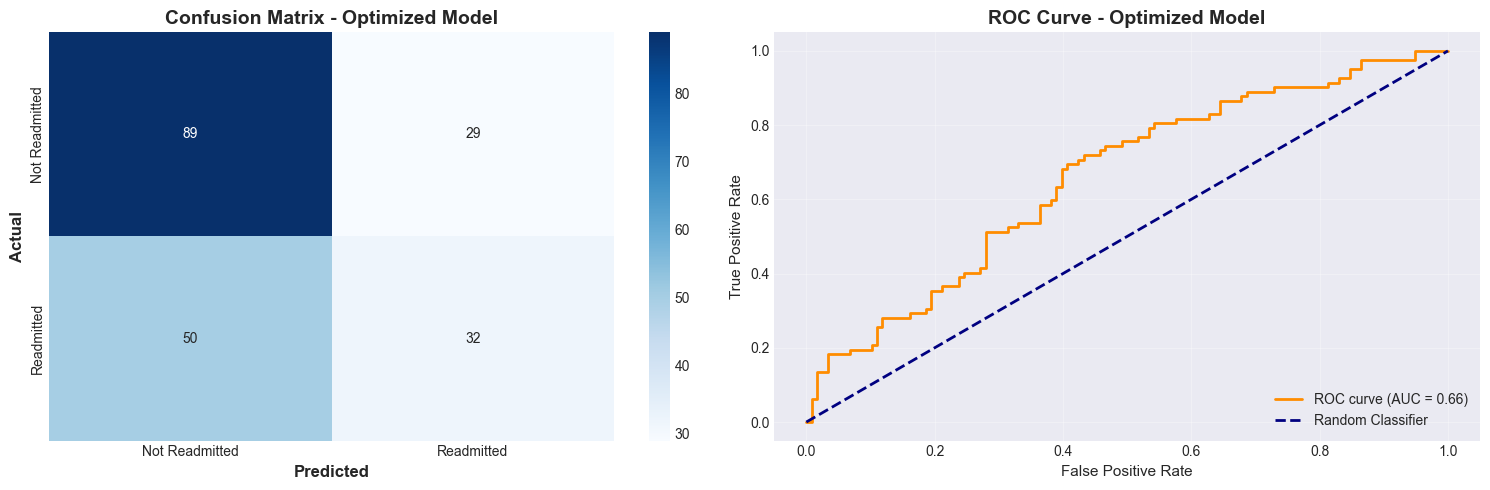

ROC AUC Score: 0.6593


In [7]:
print("\n" + "="*60)
print("STEP 3: MODEL TRAINING AND EVALUATION")
print("="*60)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled!")

# Train initial model
model_initial = LogisticRegression(random_state=42, max_iter=1000)
model_initial.fit(X_train_scaled, y_train)

print("✓ Initial model trained!")

# Train optimized model
model_optimized = LogisticRegression(C=0.1, penalty='l2', random_state=42, max_iter=1000)
model_optimized.fit(X_train_scaled, y_train)

print("✓ Optimized model trained!")

# Evaluate optimized model
y_pred_optimized = model_optimized.predict(X_test_scaled)
y_pred_proba_optimized = model_optimized.predict_proba(X_test_scaled)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)

cm_optimized = confusion_matrix(y_test, y_pred_optimized)

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_optimized:.4f}")
print(f"Precision: {precision_optimized:.4f}")
print(f"Recall:    {recall_optimized:.4f}")
print(f"F1-Score:  {f1_optimized:.4f}")

print(f"\nConfusion Matrix:")
print(cm_optimized)

# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix Heatmap
ax1 = axes[0]
cm_display = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix - Optimized Model', fontsize=14, fontweight='bold')

# 2. ROC Curve
ax2 = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_optimized)
roc_auc = roc_auc_score(y_test, y_pred_proba_optimized)
ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Optimized Model', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

## Step 4: Save Model and Scaler

In [8]:
print("\n" + "="*60)
print("STEP 4: SAVE MODEL AND SCALER")
print("="*60)

# Save the optimized model
model_path = src_dir / 'readmission_model.joblib'
joblib.dump(model_optimized, model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = src_dir / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Verify loading
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
test_predictions = loaded_model.predict(loaded_scaler.transform(X_test.iloc[:5]))
print("✓ Model and scaler loading verified!")

print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print("The trained model and scaler are ready for deployment.")
print("Run 'streamlit run app.py' to launch the prediction app.")


STEP 4: SAVE MODEL AND SCALER
✓ Model saved to: src\readmission_model.joblib
✓ Scaler saved to: src\scaler.joblib
✓ Model and scaler loading verified!

PIPELINE COMPLETED SUCCESSFULLY!
The trained model and scaler are ready for deployment.
Run 'streamlit run app.py' to launch the prediction app.
